# **Ejercicio 1: Predicción de Riesgo de Diabetes**

Descripción:
Utiliza un dataset que incluye datos sobre registros médicos de pacientes femeninas para
determinar si un paciente tiene diabetes o no.

# ***1. Carga y exploración general de los datos***

In [32]:
%pip install polars
import polars as pl


In [34]:
%pip install numpy
import numpy as np

In [35]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, roc_curve, auc)

In [36]:
# Cargar los datos
df = pl.read_csv("diabetes.csv")

In [37]:
# Exploración inicial
print("Primeras filas:")
print(df.head())

print("\nInformación del dataset:")
print(f"Filas: {df.height}, Columnas: {df.width}")
print("\nTipos de datos:")
print(df.schema)

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores nulos por columna:")
print(df.null_count())

Primeras filas:
shape: (5, 9)
┌─────────────┬─────────┬───────────────┬───────────────┬───┬──────┬───────────────┬─────┬─────────┐
│ Pregnancies ┆ Glucose ┆ BloodPressure ┆ SkinThickness ┆ … ┆ BMI  ┆ DiabetesPedig ┆ Age ┆ Outcome │
│ ---         ┆ ---     ┆ ---           ┆ ---           ┆   ┆ ---  ┆ reeFunction   ┆ --- ┆ ---     │
│ i64         ┆ i64     ┆ i64           ┆ i64           ┆   ┆ f64  ┆ ---           ┆ i64 ┆ i64     │
│             ┆         ┆               ┆               ┆   ┆      ┆ f64           ┆     ┆         │
╞═════════════╪═════════╪═══════════════╪═══════════════╪═══╪══════╪═══════════════╪═════╪═════════╡
│ 6           ┆ 148     ┆ 72            ┆ 35            ┆ … ┆ 33.6 ┆ 0.627         ┆ 50  ┆ 1       │
│ 1           ┆ 85      ┆ 66            ┆ 29            ┆ … ┆ 26.6 ┆ 0.351         ┆ 31  ┆ 0       │
│ 8           ┆ 183     ┆ 64            ┆ 0             ┆ … ┆ 23.3 ┆ 0.672         ┆ 32  ┆ 1       │
│ 1           ┆ 89      ┆ 66            ┆ 23            ┆ … ┆

# ***2. Limpieza básica***


In [38]:
# Verificar y eliminar duplicados
print(f"Número de duplicados: {df.height - df.unique().height}")
df = df.unique()

Número de duplicados: 0


In [44]:
# Reemplazar ceros en ciertas columnas donde no tienen sentido
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    df = df.with_columns(
        pl.when(pl.col(col) == 0)
        .then(None)
        .otherwise(pl.col(col))
        .alias(col)
    )

In [45]:
# Imputar valores faltantes con la mediana
for col in zero_cols:
    median_val = df.select(pl.col(col).median()).item()
    df = df.with_columns(
        pl.col(col).fill_null(median_val)
    )

In [46]:
# Verificar que no quedan valores nulos
print("\nValores nulos después de limpieza:")
print(df.null_count())


Valores nulos después de limpieza:
shape: (1, 9)
┌─────────────┬─────────┬───────────────┬───────────────┬───┬─────┬────────────────┬─────┬─────────┐
│ Pregnancies ┆ Glucose ┆ BloodPressure ┆ SkinThickness ┆ … ┆ BMI ┆ DiabetesPedigr ┆ Age ┆ Outcome │
│ ---         ┆ ---     ┆ ---           ┆ ---           ┆   ┆ --- ┆ eeFunction     ┆ --- ┆ ---     │
│ u32         ┆ u32     ┆ u32           ┆ u32           ┆   ┆ u32 ┆ ---            ┆ u32 ┆ u32     │
│             ┆         ┆               ┆               ┆   ┆     ┆ u32            ┆     ┆         │
╞═════════════╪═════════╪═══════════════╪═══════════════╪═══╪═════╪════════════════╪═════╪═════════╡
│ 0           ┆ 0       ┆ 0             ┆ 0             ┆ … ┆ 0   ┆ 0              ┆ 0   ┆ 0       │
└─────────────┴─────────┴───────────────┴───────────────┴───┴─────┴────────────────┴─────┴─────────┘


# ***3. Análisis exploratorio + visualización inicial***

Text(0.5, 1.0, 'Distribución de Diabetes')

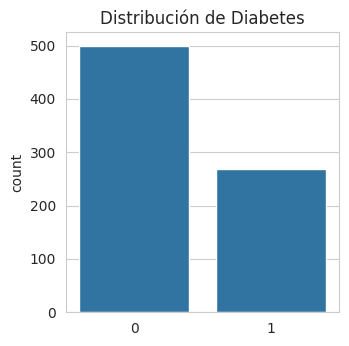

In [50]:
# Configurar estilo de visualización
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Distribución de la variable objetivo
plt.subplot(2, 3, 1)
sns.countplot(x=df['Outcome'].to_numpy())
plt.title('Distribución de Diabetes')


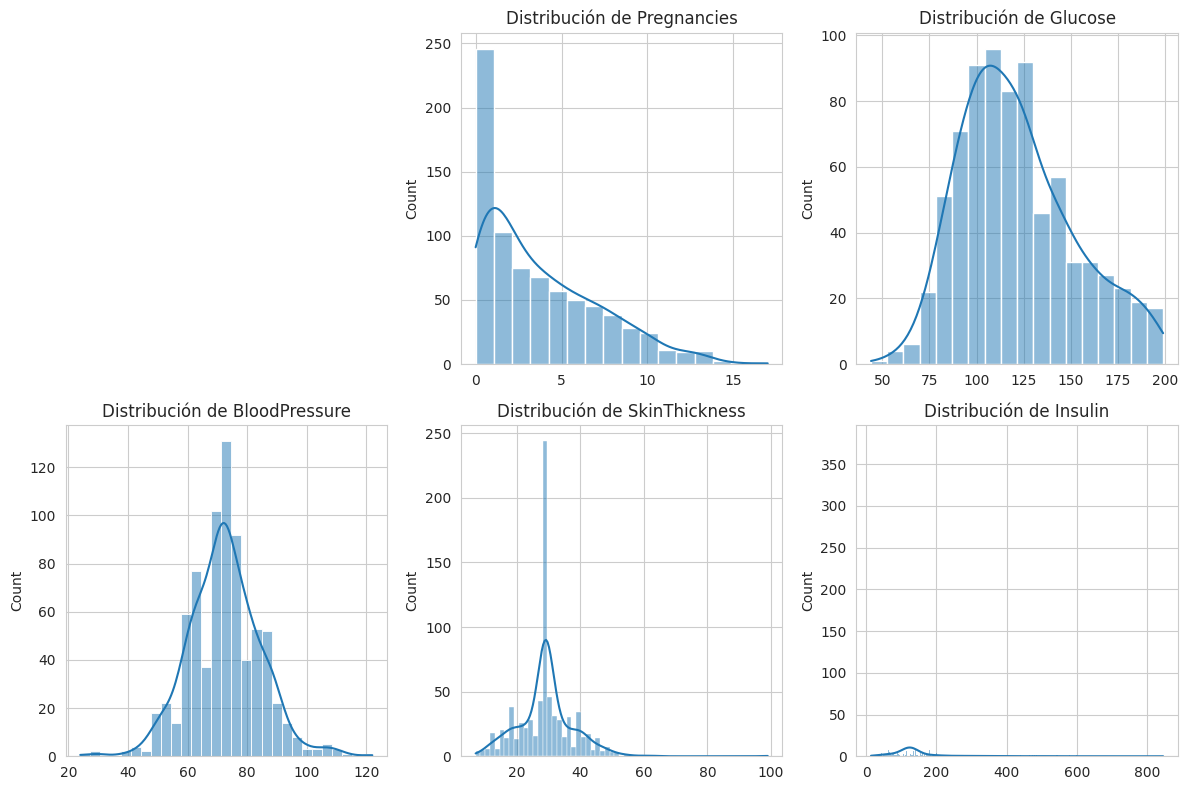

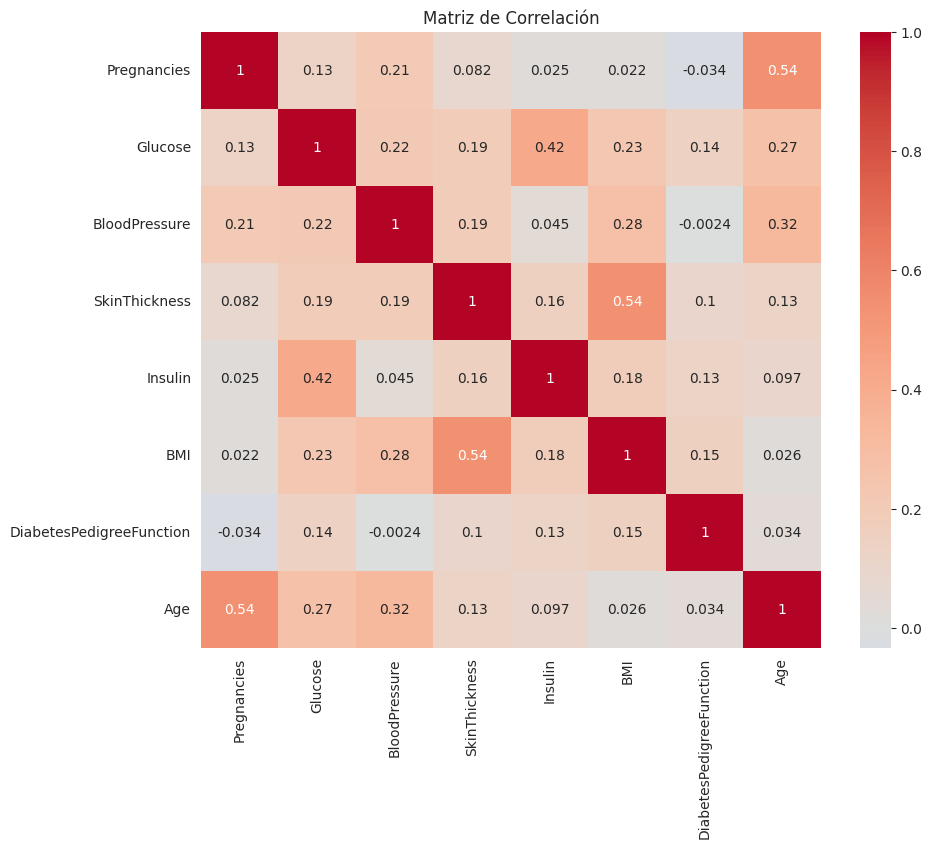

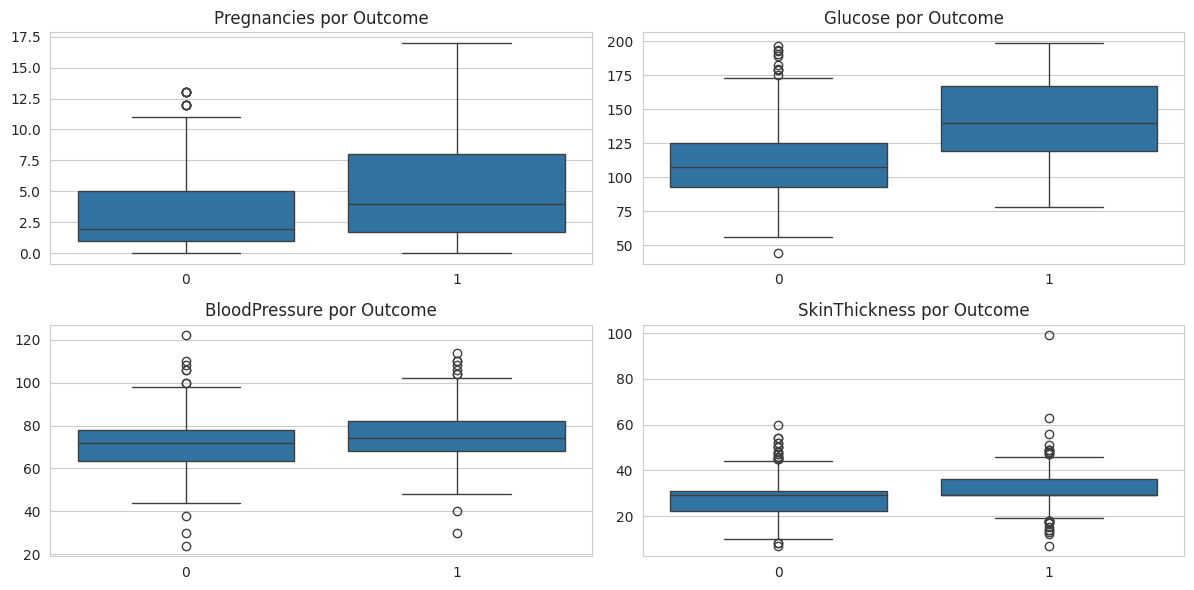

In [15]:
# Configurar estilo de visualización
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))


# Histogramas de variables numéricas
numeric_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
               'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for i, col in enumerate(numeric_cols[:5], start=2):
    plt.subplot(2, 3, i)
    sns.histplot(df[col].to_numpy(), kde=True)
    plt.title(f'Distribución de {col}')

plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = df.select(pl.all().exclude('Outcome')).to_pandas().corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

# Boxplots por Outcome
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols[:4], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df['Outcome'].to_numpy(), y=df[col].to_numpy())
    plt.title(f'{col} por Outcome')
plt.tight_layout()
plt.show()

# ***4. Preprocesamiento técnico***

In [17]:
# Separar características y objetivo
X = df.select(pl.all().exclude('Outcome')).to_numpy()
y = df['Outcome'].to_numpy()

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ***5. Entrenamiento del modelo de ML***

In [18]:
# Modelos a evaluar
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [19]:
# Entrenar y evaluar cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy_score(y_test, y_pred)
    }
    print(f"{name} - Accuracy: {results[name]['accuracy']:.2f}")

Regresión Logística - Accuracy: 0.76
KNN - Accuracy: 0.75
Random Forest - Accuracy: 0.72


# ***6. Evaluación del modelo***


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       150
           1       0.74      0.49      0.59        81

    accuracy                           0.76       231
   macro avg       0.75      0.70      0.71       231
weighted avg       0.76      0.76      0.75       231


Matriz de confusión:


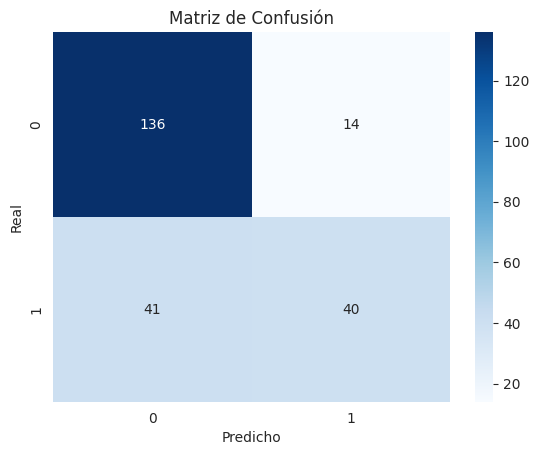

In [21]:
# Evaluación detallada del mejor modelo (Random Forest probablemente)
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
y_pred = best_model.predict(X_test_scaled)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusión:")
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

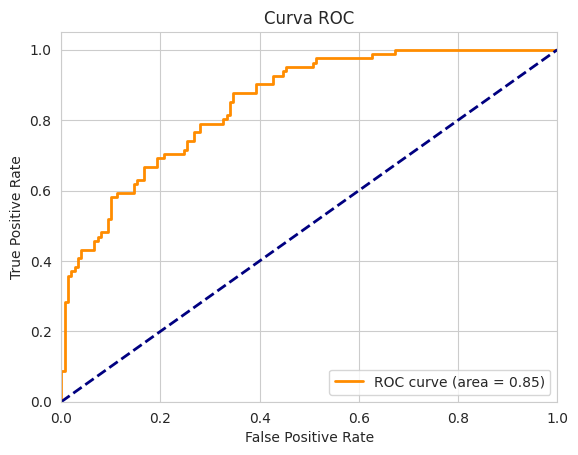

In [22]:
# Curva ROC
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# ***7. Visualización de resultados y métricas***

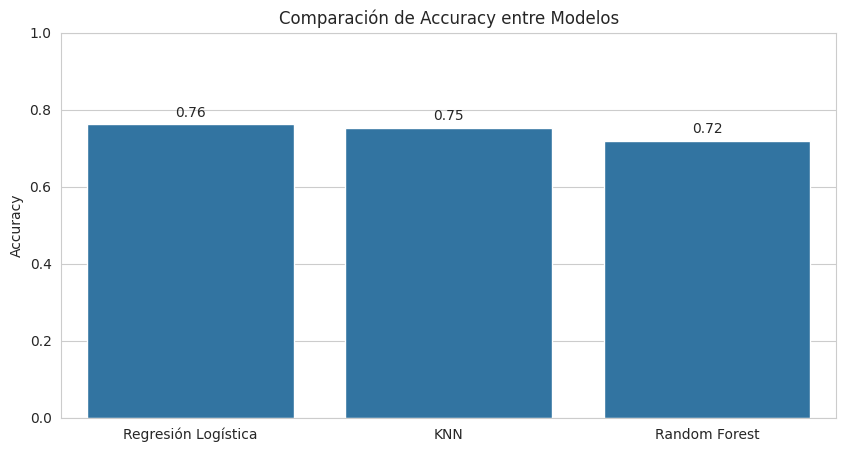

In [23]:
# Comparación de modelos
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies)
plt.title('Comparación de Accuracy entre Modelos')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.show()

# Importancia de características (para Random Forest)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    features = df.columns[:-1]  # Excluir Outcome

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=features)
    plt.title('Importancia de Características (Random Forest)')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.show()